# Regularization

In [1]:
import numpy as np
import scipy.io
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
data = scipy.io.loadmat('PlanarData.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Sun Nov 13 14:29:06 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-1.58986e-01,  4.23977e-01],
        [-3.47926e-01,  4.70760e-01],
        [-5.04608e-01,  3.53801e-01],
        [-5.96774e-01,  1.14035e-01],
        [-5.18433e-01, -1.72515e-01],
        [-2.92627e-01, -2.07602e-01],
        [-1.58986e-01, -4.38596e-02],
        [-5.76037e-02,  1.43275e-01],
        [-7.14286e-02,  2.71930e-01],
        [-2.97235e-01,  3.47953e-01],
        [-4.17051e-01,  2.01754e-01],
        [-4.40092e-01,  8.77193e-03],
        [-3.24885e-01, -3.21637e-02],
        [-2.46544e-01,  5.55556e-02],
        [-2.18894e-01,  2.01754e-01],
        [-3.43318e-01,  1.60819e-01],
        [-5.09217e-01,  7.89474e-02],
        [-3.84793e-01, -9.06433e-02],
        [-1.49770e-01,  1.25731e-01],
        [-1.95853e-01,  3.24561e-01],
        [-3.91705e-02, -2.19298e-01],
        [-1.08295e-01, -3.01170e-01],
        [-1.86636e-0

In [3]:
X_train = np.array(data['X'], dtype='float32')
Y_train = np.array(data['y'], dtype='float32')

X_test = np.array(data['Xval'], dtype='float32')
Y_test = np.array(data['yval'], dtype='float32')

X = np.concatenate((X_train, X_test), axis=0)
Y = np.concatenate((Y_train, Y_test), axis=0)

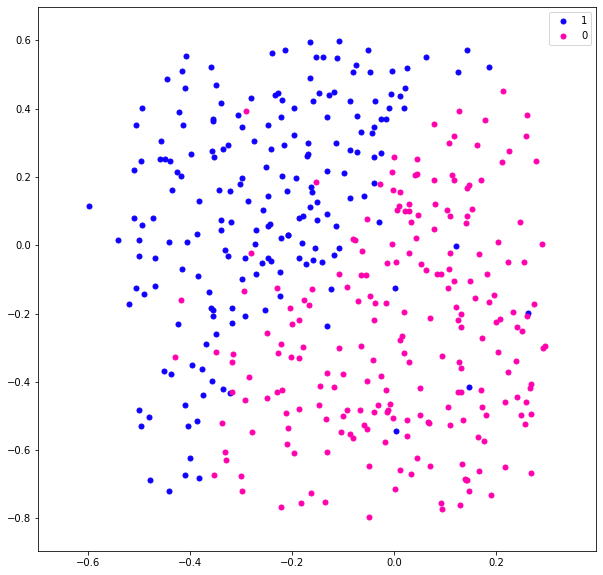

In [4]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, np.min(X[:,1])-0.1, np.max(X[:,1])+0.1])
pos = np.where(Y[:,0] == 1)[0]
neg = np.where(Y[:,0] == 0)[0]
ax.plot(X[pos,0], X[pos,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='1') 
ax.plot(X[neg,0], X[neg,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='0')
ax.legend()

In [5]:
class Layer1():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def build(self):
        self.weights = []
        self.mu = tf.zeros(shape=(1,self.output_dim), dtype="float32")
        self.sigma = tf.ones(shape=(1,self.output_dim), dtype="float32")

    def __call__(self, inputs):
        return (inputs-self.mu)/self.sigma
    
class Layer2():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.maximum(0.,u)
    
class Layer3():
    
    def __init__(self, model, input_dim, output_dim):
        self.model = model
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.build()
        
    def add_weight(self, shape):
        weight_init = tf.random.normal(shape=shape, mean=0.0, stddev=0.05, dtype="float32")
        return tf.Variable(initial_value=weight_init, trainable=True)
        
    def build(self):
        self.w = self.add_weight(shape=(self.output_dim, self.input_dim))
        self.b = self.add_weight(shape=(self.output_dim, 1))
        self.weights = [self.w, self.b]

    def __call__(self, inputs):
        z = tf.matmul(self.w, tf.transpose(inputs)) + self.b
        u = tf.transpose(z)
        return tf.math.sigmoid(u)

In [6]:
class LossFunction():
        
    def __init__(self, model, p, alpha):
        self.model = model
        self.p = p 
        self.alpha = alpha
            
    def __call__(self, y_true, y_pred):
        loss = -tf.math.reduce_mean(y_true*tf.math.log(y_pred) + (1-y_true)*tf.math.log(1-y_pred))
        regularization = 0
        for i in range(len(self.model.weights)):
            regularization = regularization + tf.reduce_sum(tf.math.pow(tf.math.abs(self.model.weights[i]), self.p)) 
        return loss + self.alpha*regularization

In [7]:
class MetricFunction():
        
    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold
            
    def __call__(self, y_true, y_pred):
        y_pred_ = tf.sign(1+tf.sign(y_pred-self.threshold))
        return tf.math.reduce_mean(1-tf.square(tf.sign(y_true-y_pred_))) 

In [8]:
class Optimizer():
    
    def __init__(self, model, learning_rate, batch_size):
        self.model = model
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.stop_training = False
        
    def apply(self, grads, weights):
        for i in range(len(weights)):
            w = weights[i]
            grad_w = grads[i]
            weights[i].assign(w - self.learning_rate*grad_w)
            
    def train_step(self, X, Y):
        num_batches = X.shape[0]//self.batch_size
        for batch in range(num_batches+1):
            if batch<num_batches:
                X_batch = X[batch*self.batch_size:(batch+1)*self.batch_size,:]
                Y_batch = Y[batch*self.batch_size:(batch+1)*self.batch_size,:]
            else:
                X_batch = X[batch:,:]
                Y_batch = Y[batch:,:]
            with tf.GradientTape() as tape:
                H = self.model(X_batch)
                loss = self.model.loss(Y_batch, H)
            grads = tape.gradient(loss, self.model.weights)
            self.apply(grads, self.model.weights)    
        H = self.model(X)
        loss = self.model.loss(Y, H)
        metric = self.model.metric(Y, H)
        logs = {'loss': loss,
                'metric': metric}
        return logs

In [9]:
class Callback1():

    def __init__(self, model, verbose):
        self.model = model
        self.verbose = verbose
    
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = tf.timestamp()
        
    def on_epoch_end(self, epoch, logs=None):
        if self.verbose:
            now = tf.timestamp()
            time = now - self.start_time
            tf.print('Epochs {}/{} - Loss: {} - Metric: {}'.format(epoch+1, self.model.epochs, logs['loss'], logs['metric']))
            tf.print('----- {}s -----'.format(tf.round(1000*time)/1000))
            
class Callback2():

    def __init__(self, model):
        self.model = model
        self.history = {'loss':[],
                        'metric':[]}
        
    def on_epoch_end(self, epoch, logs):
        self.history['loss'].append(logs['loss'].numpy())
        self.history['metric'].append(logs['metric'].numpy())
        
    def on_train_end(self):
        self.model.history = self.history

class Callback3():
        
    def __init__(self, model, patience, error, reduce_factor, min_learning_rate):
        self.model = model
        self.patience = patience
        self.error = error
        self.reduce_factor = reduce_factor
        self.min_learning_rate = min_learning_rate
                        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            if (self.model.optimizer.learning_rate>self.min_learning_rate):
                self.model.optimizer.learning_rate = self.reduce_factor*self.model.optimizer.learning_rate
                self.non_decreasing_epochs = 0
        
class Callback4():
        
    def __init__(self, model, patience, error):
        self.model = model
        self.patience = patience
        self.error = error
        
    def on_epoch_end(self, epoch, logs):
        if epoch==0:
            self.loss = logs['loss']
            self.non_decreasing_epochs = 0
        else:
            if ((self.loss-logs['loss'])>self.error):
                self.loss = logs['loss']
                self.non_decreasing_epochs = 0
            else:
                self.non_decreasing_epochs = self.non_decreasing_epochs+1
        if (self.non_decreasing_epochs == self.patience):
            self.model.optimizer.stop_training = True

In [10]:
class NN():
    
    def __init__(self, dims):
        self.dims = dims
        self.build()
    
    def build(self):
        self.layers = []
        self.layers.append(Layer1(model=self, input_dim=self.dims[0], output_dim=self.dims[0]))
        for i in range(len(self.dims)-2):
            self.layers.append(Layer2(model=self, input_dim=self.dims[i], output_dim=self.dims[i+1]))
        self.layers.append(Layer3(model=self, input_dim=self.dims[-2], output_dim=self.dims[-1]))
        self.weights = []
        for layer in self.layers:
            for weight in layer.weights:
                self.weights.append(weight)
        
    def __call__(self, inputs):
        y = inputs
        for layer in self.layers:
            y = layer(y)
        return y 
        
    def train_setup(self, p, alpha, epochs, learning_rate, batch_size, threshold, verbose):
        self.p = p
        self.alpha = alpha
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.batch_size = batch_size
        self.threshold = threshold
        self.verbose = verbose
        self.loss = LossFunction(model=self, p=self.p, alpha=self.alpha)
        self.metric = MetricFunction(model=self, threshold=self.threshold)
        self.optimizer = Optimizer(model=self, learning_rate=self.learning_rate, batch_size=self.batch_size)
        self.callbacks = [Callback1(model=self, verbose=self.verbose),
                          Callback2(model=self),
                          Callback3(model=self, patience=1000, error=0.001, reduce_factor=0.1, min_learning_rate=0.001),
                          Callback4(model=self, patience=2000, error=0.001)]
        
    def fit(self, X, Y, p=2, alpha=0.01, epochs=1000, learning_rate=0.01, batch_size=32, threshold=0.5, verbose=True):
        self.layers[0].mu = tf.math.reduce_mean(tf.constant(X, dtype="float32"), axis=0)
        self.layers[0].sigma = tf.math.reduce_std(tf.constant(X, dtype="float32"), axis=0)
        self.train_setup(p, alpha, epochs, learning_rate, batch_size, threshold, verbose)
        if verbose:
            print('Train on {} samples'.format(X.shape[0]))
        for epoch in range(self.epochs):
            self.callbacks[0].on_epoch_begin(epoch)
            logs = self.optimizer.train_step(tf.constant(X, dtype="float32"), tf.constant(Y, dtype="float32"))
            for callback in self.callbacks:
                callback.on_epoch_end(epoch, logs)
            if self.optimizer.stop_training:
                break
        self.callbacks[1].on_train_end()
            
    def predict(self, inputs):
        return self(tf.constant(inputs, dtype="float32")).numpy()
    
    def evaluate(self, X, Y):
        loss = self.loss(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        loss_numpy = loss.numpy()
        metric = self.metric(tf.constant(Y, dtype="float32"), self(tf.constant(X, dtype="float32")))
        metric_numpy = metric.numpy()
        tf.print('Loss: {} - Metric: {}'.format(loss_numpy, metric_numpy))
        return [loss_numpy, metric_numpy]

In [11]:
nn = NN(dims=[X_train.shape[1], 32, 32, Y_train.shape[1]])

nn.fit(X_train, Y_train)

Train on 211 samples
Epochs 1/1000 - Loss: 0.7225399017333984 - Metric: 0.4976303279399872
----- 0.072s -----
Epochs 2/1000 - Loss: 0.722388744354248 - Metric: 0.4976303279399872
----- 0.057s -----
Epochs 3/1000 - Loss: 0.7222379446029663 - Metric: 0.4976303279399872
----- 0.053s -----
Epochs 4/1000 - Loss: 0.7220882773399353 - Metric: 0.4976303279399872
----- 0.051s -----
Epochs 5/1000 - Loss: 0.7219394445419312 - Metric: 0.4976303279399872
----- 0.049s -----
Epochs 6/1000 - Loss: 0.7217915654182434 - Metric: 0.4976303279399872
----- 0.055s -----
Epochs 7/1000 - Loss: 0.721645176410675 - Metric: 0.4976303279399872
----- 0.053s -----
Epochs 8/1000 - Loss: 0.7214995622634888 - Metric: 0.4976303279399872
----- 0.051s -----
Epochs 9/1000 - Loss: 0.7213544249534607 - Metric: 0.4976303279399872
----- 0.053s -----
Epochs 10/1000 - Loss: 0.7212101221084595 - Metric: 0.4976303279399872
----- 0.052s -----
Epochs 11/1000 - Loss: 0.7210665941238403 - Metric: 0.4976303279399872
----- 0.051s -----


----- 0.051s -----
Epochs 93/1000 - Loss: 0.7101931571960449 - Metric: 0.4976303279399872
----- 0.061s -----
Epochs 94/1000 - Loss: 0.7100433111190796 - Metric: 0.4976303279399872
----- 0.061s -----
Epochs 95/1000 - Loss: 0.7098922729492188 - Metric: 0.4976303279399872
----- 0.062s -----
Epochs 96/1000 - Loss: 0.7097392082214355 - Metric: 0.4976303279399872
----- 0.071s -----
Epochs 97/1000 - Loss: 0.7095848321914673 - Metric: 0.4976303279399872
----- 0.058s -----
Epochs 98/1000 - Loss: 0.7094293832778931 - Metric: 0.4976303279399872
----- 0.063s -----
Epochs 99/1000 - Loss: 0.7092723846435547 - Metric: 0.4976303279399872
----- 0.11s -----
Epochs 100/1000 - Loss: 0.7091141939163208 - Metric: 0.4976303279399872
----- 0.063s -----
Epochs 101/1000 - Loss: 0.7089545130729675 - Metric: 0.4976303279399872
----- 0.054s -----
Epochs 102/1000 - Loss: 0.7087933421134949 - Metric: 0.4976303279399872
----- 0.048s -----
Epochs 103/1000 - Loss: 0.7086305022239685 - Metric: 0.4976303279399872
----- 0

----- 0.052s -----
Epochs 184/1000 - Loss: 0.6820204854011536 - Metric: 0.7725118398666382
----- 0.051s -----
Epochs 185/1000 - Loss: 0.6813387870788574 - Metric: 0.7725118398666382
----- 0.051s -----
Epochs 186/1000 - Loss: 0.680641233921051 - Metric: 0.7772511839866638
----- 0.052s -----
Epochs 187/1000 - Loss: 0.679926872253418 - Metric: 0.7819905281066895
----- 0.059s -----
Epochs 188/1000 - Loss: 0.6791948080062866 - Metric: 0.7819905281066895
----- 0.056s -----
Epochs 189/1000 - Loss: 0.6784443855285645 - Metric: 0.7867298722267151
----- 0.058s -----
Epochs 190/1000 - Loss: 0.6776751279830933 - Metric: 0.8009478449821472
----- 0.052s -----
Epochs 191/1000 - Loss: 0.6768866181373596 - Metric: 0.8151658773422241
----- 0.05s -----
Epochs 192/1000 - Loss: 0.676079273223877 - Metric: 0.8151658773422241
----- 0.054s -----
Epochs 193/1000 - Loss: 0.6752519011497498 - Metric: 0.8199052214622498
----- 0.064s -----
Epochs 194/1000 - Loss: 0.6744035482406616 - Metric: 0.8246445655822754
---

----- 0.053s -----
Epochs 275/1000 - Loss: 0.5129997730255127 - Metric: 0.9052132964134216
----- 0.049s -----
Epochs 276/1000 - Loss: 0.5103445649147034 - Metric: 0.9052132964134216
----- 0.052s -----
Epochs 277/1000 - Loss: 0.5077078342437744 - Metric: 0.9052132964134216
----- 0.05s -----
Epochs 278/1000 - Loss: 0.5050884485244751 - Metric: 0.9099525809288025
----- 0.053s -----
Epochs 279/1000 - Loss: 0.5024888515472412 - Metric: 0.9099525809288025
----- 0.054s -----
Epochs 280/1000 - Loss: 0.49990859627723694 - Metric: 0.9099525809288025
----- 0.053s -----
Epochs 281/1000 - Loss: 0.4973490834236145 - Metric: 0.9099525809288025
----- 0.05s -----
Epochs 282/1000 - Loss: 0.49480950832366943 - Metric: 0.9099525809288025
----- 0.05s -----
Epochs 283/1000 - Loss: 0.4922885596752167 - Metric: 0.9099525809288025
----- 0.05s -----
Epochs 284/1000 - Loss: 0.48978564143180847 - Metric: 0.9099525809288025
----- 0.054s -----
Epochs 285/1000 - Loss: 0.4873019754886627 - Metric: 0.9099525809288025


Epochs 365/1000 - Loss: 0.3691043555736542 - Metric: 0.928909957408905
----- 0.059s -----
Epochs 366/1000 - Loss: 0.36849236488342285 - Metric: 0.928909957408905
----- 0.054s -----
Epochs 367/1000 - Loss: 0.36789536476135254 - Metric: 0.928909957408905
----- 0.053s -----
Epochs 368/1000 - Loss: 0.3673129975795746 - Metric: 0.928909957408905
----- 0.052s -----
Epochs 369/1000 - Loss: 0.3667443096637726 - Metric: 0.928909957408905
----- 0.052s -----
Epochs 370/1000 - Loss: 0.3661898076534271 - Metric: 0.928909957408905
----- 0.062s -----
Epochs 371/1000 - Loss: 0.36564895510673523 - Metric: 0.928909957408905
----- 0.078s -----
Epochs 372/1000 - Loss: 0.3651215136051178 - Metric: 0.928909957408905
----- 0.052s -----
Epochs 373/1000 - Loss: 0.3646073639392853 - Metric: 0.928909957408905
----- 0.054s -----
Epochs 374/1000 - Loss: 0.3641057014465332 - Metric: 0.928909957408905
----- 0.049s -----
Epochs 375/1000 - Loss: 0.3636167645454407 - Metric: 0.928909957408905
----- 0.074s -----
Epochs 

----- 0.065s -----
Epochs 456/1000 - Loss: 0.3472689390182495 - Metric: 0.9241706132888794
----- 0.077s -----
Epochs 457/1000 - Loss: 0.3472101092338562 - Metric: 0.9241706132888794
----- 0.058s -----
Epochs 458/1000 - Loss: 0.3471527695655823 - Metric: 0.9241706132888794
----- 0.056s -----
Epochs 459/1000 - Loss: 0.34709668159484863 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 460/1000 - Loss: 0.34704190492630005 - Metric: 0.9241706132888794
----- 0.059s -----
Epochs 461/1000 - Loss: 0.3469882011413574 - Metric: 0.9241706132888794
----- 0.056s -----
Epochs 462/1000 - Loss: 0.3469356596469879 - Metric: 0.9241706132888794
----- 0.049s -----
Epochs 463/1000 - Loss: 0.3468848168849945 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 464/1000 - Loss: 0.346835196018219 - Metric: 0.9241706132888794
----- 0.059s -----
Epochs 465/1000 - Loss: 0.34678661823272705 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 466/1000 - Loss: 0.3467389643192291 - Metric: 0.924170613288879

----- 0.053s -----
Epochs 546/1000 - Loss: 0.34419044852256775 - Metric: 0.9241706132888794
----- 0.053s -----
Epochs 547/1000 - Loss: 0.3441639244556427 - Metric: 0.9241706132888794
----- 0.061s -----
Epochs 548/1000 - Loss: 0.3441374897956848 - Metric: 0.9241706132888794
----- 0.071s -----
Epochs 549/1000 - Loss: 0.3441111445426941 - Metric: 0.9241706132888794
----- 0.065s -----
Epochs 550/1000 - Loss: 0.34408634901046753 - Metric: 0.9241706132888794
----- 0.063s -----
Epochs 551/1000 - Loss: 0.3440621495246887 - Metric: 0.9241706132888794
----- 0.065s -----
Epochs 552/1000 - Loss: 0.3440386652946472 - Metric: 0.9241706132888794
----- 0.062s -----
Epochs 553/1000 - Loss: 0.34401458501815796 - Metric: 0.9241706132888794
----- 0.068s -----
Epochs 554/1000 - Loss: 0.3439902067184448 - Metric: 0.9241706132888794
----- 0.058s -----
Epochs 555/1000 - Loss: 0.3439660370349884 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 556/1000 - Loss: 0.34394127130508423 - Metric: 0.924170613288

----- 0.048s -----
Epochs 636/1000 - Loss: 0.3426193296909332 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 637/1000 - Loss: 0.3426005244255066 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 638/1000 - Loss: 0.3425810933113098 - Metric: 0.9241706132888794
----- 0.052s -----
Epochs 639/1000 - Loss: 0.3425624370574951 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 640/1000 - Loss: 0.34254390001296997 - Metric: 0.9241706132888794
----- 0.049s -----
Epochs 641/1000 - Loss: 0.34252533316612244 - Metric: 0.9241706132888794
----- 0.053s -----
Epochs 642/1000 - Loss: 0.3425067663192749 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 643/1000 - Loss: 0.3424879014492035 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 644/1000 - Loss: 0.3424696922302246 - Metric: 0.9241706132888794
----- 0.049s -----
Epochs 645/1000 - Loss: 0.34245163202285767 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 646/1000 - Loss: 0.3424336314201355 - Metric: 0.9241706132888794

----- 0.053s -----
Epochs 726/1000 - Loss: 0.3411514461040497 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 727/1000 - Loss: 0.34113967418670654 - Metric: 0.9241706132888794
----- 0.053s -----
Epochs 728/1000 - Loss: 0.3411253094673157 - Metric: 0.9241706132888794
----- 0.055s -----
Epochs 729/1000 - Loss: 0.3411136269569397 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 730/1000 - Loss: 0.3410986065864563 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 731/1000 - Loss: 0.34108656644821167 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 732/1000 - Loss: 0.34107494354248047 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 733/1000 - Loss: 0.3410605192184448 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 734/1000 - Loss: 0.3410491943359375 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 735/1000 - Loss: 0.3410375714302063 - Metric: 0.9241706132888794
----- 0.049s -----
Epochs 736/1000 - Loss: 0.3410225510597229 - Metric: 0.924170613288879

----- 0.049s -----
Epochs 816/1000 - Loss: 0.3400207757949829 - Metric: 0.9241706132888794
----- 0.049s -----
Epochs 817/1000 - Loss: 0.34000760316848755 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 818/1000 - Loss: 0.33999893069267273 - Metric: 0.9241706132888794
----- 0.052s -----
Epochs 819/1000 - Loss: 0.3399849236011505 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 820/1000 - Loss: 0.3399766683578491 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 821/1000 - Loss: 0.33996760845184326 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 822/1000 - Loss: 0.33995360136032104 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 823/1000 - Loss: 0.33994534611701965 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 824/1000 - Loss: 0.339931845664978 - Metric: 0.9241706132888794
----- 0.05s -----
Epochs 825/1000 - Loss: 0.33992379903793335 - Metric: 0.9241706132888794
----- 0.048s -----
Epochs 826/1000 - Loss: 0.33991166949272156 - Metric: 0.924170613288

----- 0.055s -----
Epochs 906/1000 - Loss: 0.3391575813293457 - Metric: 0.9241706132888794
----- 0.059s -----
Epochs 907/1000 - Loss: 0.33915048837661743 - Metric: 0.9241706132888794
----- 0.052s -----
Epochs 908/1000 - Loss: 0.33914291858673096 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 909/1000 - Loss: 0.33913344144821167 - Metric: 0.9241706132888794
----- 0.053s -----
Epochs 910/1000 - Loss: 0.3391282558441162 - Metric: 0.9241706132888794
----- 0.055s -----
Epochs 911/1000 - Loss: 0.33912041783332825 - Metric: 0.9241706132888794
----- 0.052s -----
Epochs 912/1000 - Loss: 0.3391090929508209 - Metric: 0.9241706132888794
----- 0.065s -----
Epochs 913/1000 - Loss: 0.33910247683525085 - Metric: 0.9241706132888794
----- 0.064s -----
Epochs 914/1000 - Loss: 0.3390967845916748 - Metric: 0.9241706132888794
----- 0.051s -----
Epochs 915/1000 - Loss: 0.33908891677856445 - Metric: 0.9241706132888794
----- 0.055s -----
Epochs 916/1000 - Loss: 0.3390791714191437 - Metric: 0.9241706132

----- 0.059s -----
Epochs 996/1000 - Loss: 0.338484525680542 - Metric: 0.9241706132888794
----- 0.055s -----
Epochs 997/1000 - Loss: 0.33847883343696594 - Metric: 0.9241706132888794
----- 0.054s -----
Epochs 998/1000 - Loss: 0.33847272396087646 - Metric: 0.9241706132888794
----- 0.057s -----
Epochs 999/1000 - Loss: 0.3384634256362915 - Metric: 0.9241706132888794
----- 0.055s -----
Epochs 1000/1000 - Loss: 0.3384580612182617 - Metric: 0.9241706132888794
----- 0.057s -----


In [12]:
nn.evaluate(X_train, Y_train)

Loss: 0.3384580612182617 - Metric: 0.9241706132888794


[0.33845806, 0.9241706]

In [13]:
nn.evaluate(X_test, Y_test)

Loss: 0.349983274936676 - Metric: 0.925000011920929


[0.34998327, 0.925]

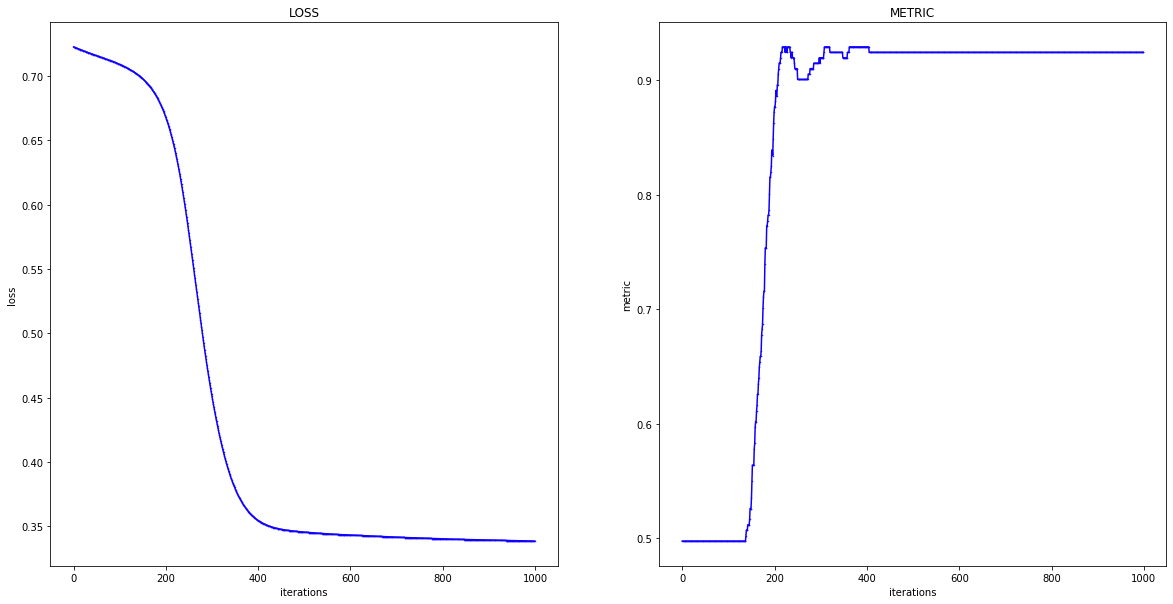

In [14]:
loss = nn.history['loss']
metric = nn.history['metric']

fig = plt.figure(figsize=(20, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.set_title('LOSS')
ax1.set_xlabel('iterations')
ax1.set_ylabel('loss')
ax1.plot(loss, marker='.', color='#0F00FF', markersize=1, linestyle='-')
ax2 = fig.add_subplot(1, 2, 2)
ax2.set_title('METRIC')
ax2.set_xlabel('iterations')
ax2.set_ylabel('metric')
ax2.plot(metric, marker='.', color='#0F00FF', markersize=1, linestyle='-')

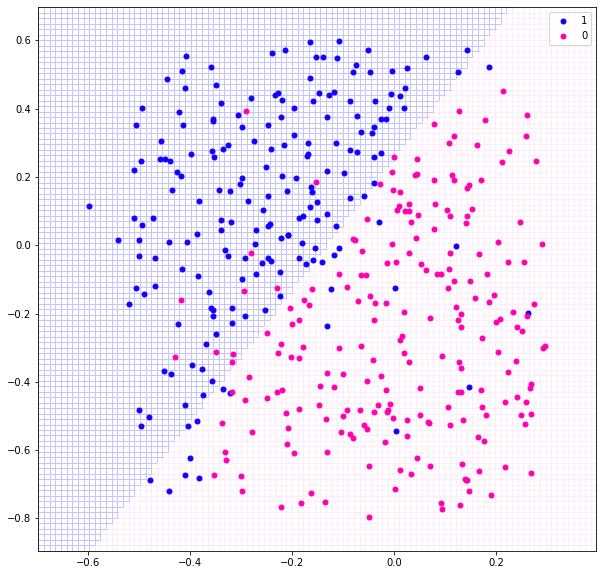

In [15]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.axis([np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, np.min(X[:,1])-0.1, np.max(X[:,1])+0.1])
u = np.linspace(np.min(X[:,0])-0.1, np.max(X[:,0])+0.1, 100)
v = np.linspace(np.min(X[:,1])-0.1, np.max(X[:,1])+0.1, 100)
z = []
for i in range(100):
    for j in range(100):
        z.append([u[i], v[j]])
z = np.array(z)
w = (nn.predict(z)[:,0]>0.5).astype(int)
nn_pos = np.where(w == 1)[0]
nn_neg = np.where(w == 0)[0]
ax.plot(z[nn_pos,0], z[nn_pos,1], marker='+', color='#C7C3FF', markersize=10, linestyle='')
ax.plot(z[nn_neg,0], z[nn_neg,1], marker='+', color='#FFECFB', markersize=10, linestyle='')
pos = np.where(Y[:,0] == 1)[0]
neg = np.where(Y[:,0] == 0)[0]
ax.plot(X[pos,0], X[pos,1], marker='.', color='#0F00FF', markersize=10, linestyle='', label='1') 
ax.plot(X[neg,0], X[neg,1], marker='.', color='#FF00AE', markersize=10, linestyle='', label='0')
ax.legend()